# Ultranest comparison
----------------------
Calculate the likelihood surface of the SFH coefficients for NGC 337 for a comparison to the fragmented, multimodal distributions that we see from sampling with Ultranest.

This may also give us som eidea of how to better tune the Ultranest sampler for our problem.

As of one test, my conclusion is that there's some noise, possibly multimodality, in the true likelihood for $\psi_2$, which seems to be spreading, due to the strong three way covariance between the first 3 SFH coefficients, to the sampling of the other parameters. Possible solutions:
- Tuning the step sampler
- Looking into "fast-slow" parameters, Ultranest's solution for dealing with parameters which have either outsized or very small $d\chi^2/d\theta$

## Imports

In [3]:
import numpy as np
from tqdm import tqdm
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## Initialize Lightning

In [2]:
cat = Table.read('example_photometry/ngc337_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

l = Lightning(filter_labels, 
              lum_dist=dl, 
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              model_unc=0.10,
              print_setup_time=True)

l.flux_obs = fnu_obs * 1e3
l.flux_unc = fnu_unc * 1e3

/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:61: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


0.165 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.569 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.857 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
2.592 s elapsed total


## Calculate the surface

In [47]:
p = np.array([1,1,1,1,1,
              0.2, -1.0, 0.0,
              2, 3, 3e5, 0.01, 0.02]) # Parameters other than psi are fixed close to the mode.

# const_dim = np.array([False, False, False, False, False,
#                       False, False, True,
#                       True, False, True, False, False])

# For better sampling it might be smarter to grid the coefficients
# independently.
Npoints = 20
Npoints_fine = 30
sfh_grid = np.linspace(0, 6, Npoints) # That's a lot of likelihood evaluations
sfh_grid_fine = np.linspace(0, 6, Npoints_fine)

chi2 = np.zeros((Npoints, Npoints_fine, Npoints, Npoints, Npoints))

# This oculd be coded more efficiently, but it makes
# reassembling the 5D likelihood after the fact harder.
with tqdm(total=(Npoints**4 * Npoints_fine)) as pbar:
    for i, psi1 in enumerate(sfh_grid):
        for j, psi2 in enumerate(sfh_grid_fine):
            for k, psi3 in enumerate(sfh_grid):
                for m, psi4 in enumerate(sfh_grid):

                    pp = np.tile(p, (Npoints, 1))
                    pp[:,0] = psi1
                    pp[:,1] = psi2
                    pp[:,2] = psi3
                    pp[:,3] = psi4
                    pp[:,4] = sfh_grid

                    chi2[i,j,k,m,:] = 2 * l.get_model_likelihood(pp, negative=True)
                    
                    pbar.update(Npoints)
                

100%|██████████| 4800000/4800000 [2:28:41<00:00, 538.01it/s]  


## Save our work

In [48]:
np.save('NGC337_psi_chi2.npy', chi2)

## Marginalize

In [ ]:
#chi2 = np.load('NGC337_psi_chi2.npy')

In [49]:
dchi2 = chi2 - np.amin(chi2)
prob = np.exp(-0.5 * dchi2)

from scipy.integrate import trapz

norm = trapz(trapz(trapz(trapz(trapz(dchi2, sfh_grid, axis=0),sfh_grid_fine, axis=0), sfh_grid, axis=0), sfh_grid, axis=0), sfh_grid, axis=0)

prob = prob / norm

# Gross
psi1_post = trapz(trapz(trapz(trapz(prob, sfh_grid, axis=-1), sfh_grid, axis=-1), sfh_grid, axis=-1), sfh_grid_fine, axis=-1)
psi2_post = trapz(trapz(trapz(trapz(prob, sfh_grid, axis=0), sfh_grid, axis=-1), sfh_grid, axis=-1), sfh_grid, axis=-1)
psi3_post = trapz(trapz(trapz(trapz(prob, sfh_grid, axis=0), sfh_grid_fine, axis=0), sfh_grid, axis=-1), sfh_grid, axis=-1)
psi4_post = trapz(trapz(trapz(trapz(prob, sfh_grid, axis=0), sfh_grid_fine, axis=0), sfh_grid, axis=0), sfh_grid, axis=-1)
psi5_post = trapz(trapz(trapz(trapz(prob, sfh_grid, axis=0), sfh_grid_fine, axis=0), sfh_grid, axis=0), sfh_grid, axis=0)

# These will need to be transposed to get them from ij -> xy ordering.
psi12_post = trapz(trapz(trapz(prob, sfh_grid, axis=-1), sfh_grid, axis=-1), sfh_grid, axis=-1)
psi23_post = trapz(trapz(trapz(prob, sfh_grid, axis=0), sfh_grid, axis=-1), sfh_grid, axis=-1)


(0, 5.834740844351994e-08)

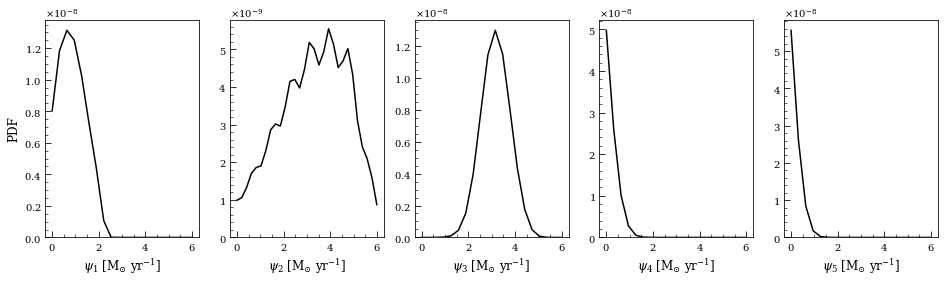

In [50]:
fig, axs = plt.subplots(1,5, figsize=(16,4))

axs[0].plot(sfh_grid, psi1_post)
axs[1].plot(sfh_grid_fine, psi2_post)
axs[2].plot(sfh_grid, psi3_post)
axs[3].plot(sfh_grid, psi4_post)
axs[4].plot(sfh_grid, psi5_post)

axs[0].set_ylabel('PDF')

axs[0].set_xlabel(r'$\psi_1\ [\rm M_{\odot}\ yr^{-1}]$')
axs[1].set_xlabel(r'$\psi_2\ [\rm M_{\odot}\ yr^{-1}]$')
axs[2].set_xlabel(r'$\psi_3\ [\rm M_{\odot}\ yr^{-1}]$')
axs[3].set_xlabel(r'$\psi_4\ [\rm M_{\odot}\ yr^{-1}]$')
axs[4].set_xlabel(r'$\psi_5\ [\rm M_{\odot}\ yr^{-1}]$')

axs[0].set_ylim(0,)
axs[1].set_ylim(0,)
axs[2].set_ylim(0,)
axs[3].set_ylim(0,)
axs[4].set_ylim(0,)


Text(0.5, 0, '$\\psi_3\\ [\\rm M_{\\odot}\\ yr^{-1}]$')

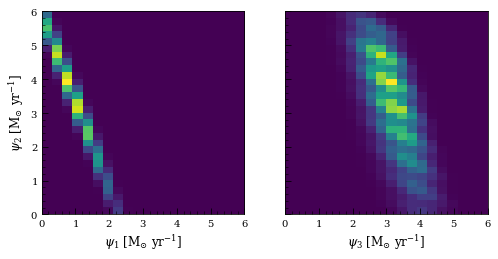

In [51]:
fig2, axs2 = plt.subplots(1,2, figsize=(8,4))

axs2[0].imshow(psi12_post.T, origin='lower', extent=[0,6,0,6])
axs2[1].imshow(psi23_post, origin='lower', extent=[0,6,0,6])

axs2[1].set_yticklabels([])

axs2[0].set_xlabel(r'$\psi_1\ [\rm M_{\odot}\ yr^{-1}]$')
axs2[0].set_ylabel(r'$\psi_2\ [\rm M_{\odot}\ yr^{-1}]$')

axs2[1].set_xlabel(r'$\psi_3\ [\rm M_{\odot}\ yr^{-1}]$')

# axs2[0].set_xlim(0,2.5)
# axs2[1].set_xlim(2,5)